# Imports and Variables

In [35]:
import os
import boto3
from botocore.exceptions import ClientError
import logging
import sagemaker
from sagemaker import get_execution_role
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from time import gmtime, strftime, sleep
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
aws_user = os.environ['AWS_USER']
aws_key = os.environ['AWS_KEY']
region_name = 'eu-central-1'

session = boto3.session.Session(
    aws_access_key_id=aws_user,
    aws_secret_access_key=aws_key,
    region_name=region_name)

s3_client = session.client('s3')
s3 = session.resource('s3')

region_name = 'eu-central-1'
bucket_name = 'niy-certification'

role = 'arn:aws:iam::898627427171:role/service-role/AmazonSageMaker-ExecutionRole-20201106T104926'

# Prepare AutoML

## Preprocessing

In [62]:
month_year = 'Apr_2019'

In [63]:
base_path = 'https://niy-certification.s3.eu-central-1.amazonaws.com/usdot/'
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
years = ['_2019', '_2020']

file_uris = {}
for year in years:
    for month in months:
        file_uris[month + year] = base_path + month + year + '_usdot.csv'

In [64]:
def get_preproccessed_df(s3_link):
    df_raw = pd.read_csv(s3_link, dtype={'DAY_OF_MONTH': str, 'CRS_ARR_TIME': str, 'CRS_DEP_TIME': str, 'WHEELS_OFF': str})
    columns_to_drop = ['YEAR', 'MONTH', 'FL_DATE', 'ORIGIN_STATE_NM', 'DEST_CITY_NAME', 'DEST_STATE_NM', 'DEP_TIME', 
                       'DEP_TIME_BLK', 'ARR_TIME', 'ARR_TIME_BLK', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 
                       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FLIGHTS', 'Unnamed: 54', 
                       'OP_CARRIER_AIRLINE_ID',	'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID',	
                       'ORIGIN_CITY_MARKET_ID',	'ORIGIN_STATE_FIPS', 'DEST_AIRPORT_ID',	'DEST_AIRPORT_SEQ_ID',	
                       'DEST_CITY_MARKET_ID', 'DEST_STATE_FIPS', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 
                       'WHEELS_ON', 'ARR_DELAY', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 
                       'AIR_TIME', 'OP_CARRIER',
                       'TAIL_NUM', # TO CHECK
                       'ORIGIN_CITY_NAME' # TO CHECK
                       ]
    # drop flights which are either canceled or diverted
    # as this is a conceptually different thing than being delayed
    df_raw = df_raw.drop(df_raw.index[(df_raw['CANCELLED'] == 1) | 
                         (df_raw['DIVERTED'] == 1)]).reset_index(drop=True)
    
    # df_raw['DAY_OF_MONTH'] = df_raw['DAY_OF_MONTH'].astype(float)
    
    df_raw = df_raw.drop(columns_to_drop, axis=1)
    df_raw = df_raw.drop(['CANCELLED', 'DIVERTED'], axis=1)
    
    # to get label column up front
    df_raw = df_raw[sorted(df_raw.columns)]
    
    return df_raw

In [66]:
df = get_preproccessed_df(file_uris[month_year])

In [14]:
'''
df['CRS_ARR_TIME_HOUR'] = df['CRS_ARR_TIME'].astype(str).str[:2]
df['CRS_ARR_TIME_MINUTE'] = df['CRS_ARR_TIME'].astype(str).str[2:]
df['CRS_DEP_TIME_HOUR'] = df['CRS_DEP_TIME'].astype(str).str[:2]
df['CRS_DEP_TIME_MINUTE'] = df['CRS_DEP_TIME'].astype(str).str[2:]
df = df.drop(['CRS_ARR_TIME', 'CRS_DEP_TIME'], axis=1)
'''

"\ndf['CRS_ARR_TIME_HOUR'] = df['CRS_ARR_TIME'].astype(str).str[:2]\ndf['CRS_ARR_TIME_MINUTE'] = df['CRS_ARR_TIME'].astype(str).str[2:]\ndf['CRS_DEP_TIME_HOUR'] = df['CRS_DEP_TIME'].astype(str).str[:2]\ndf['CRS_DEP_TIME_MINUTE'] = df['CRS_DEP_TIME'].astype(str).str[2:]\ndf = df.drop(['CRS_ARR_TIME', 'CRS_DEP_TIME'], axis=1)\n"

In [67]:
df.head(1)

,ARR_DELAY_NEW,CRS_ARR_TIME,CRS_DEP_TIME,DAY_OF_MONTH,DAY_OF_WEEK,DEST,DEST_STATE_ABR,DISTANCE,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_STATE_ABR,WHEELS_OFF
0,320.0,2008,1555,19,5,TPA,FL,1306.0,NK,MSP,MN,2126


## Train Test Split & Upload to S3

In [74]:
def split_and_upload_df(df):
    # split data
    df_train, df_test = train_test_split(df, 
                                     test_size=0.2,
                                     random_state=42)
    
    file_path_train = f'/Users/yasinedin/Downloads/automl/{month_year}train.csv'
    file_path_test = f'/Users/yasinedin/Downloads/automl/{month_year}test.csv'
    
    df_train.to_csv(file_path_train, index=False, header=True)
    df_test.drop('ARR_DELAY_NEW', axis=1).to_csv(file_path_test, index=False, header=False)
    
    # upload data to s3
    try:
        train_response = s3_client.upload_file(file_path_train, bucket_name, f'automl/{month_year}_train.csv')
        print('Train data successfully uploaded')
    except ClientError as e:
        logging.error(e)
        print('Something went wrong.')

    try:
        test_response = s3_client.upload_file(file_path_test, bucket_name, f'automl/{month_year}_test.csv')
        print('Test data successfully uploaded')
    except ClientError as e:
        logging.error(e)
        print('Something went wrong.')
        
    return print('Successfully split and uploaded data')

In [75]:
split_and_upload_df(df)

Train data successfully uploaded
Test data successfully uploaded
Successfully split and uploaded data


In [242]:
# let AutoML do its thing
"""
enc = OneHotEncoder(handle_unknown = 'ignore')

enc.fit(df_train[['OP_UNIQUE_CARRIER']])
enc.categories_

enc_columns = sorted(df_train['OP_UNIQUE_CARRIER'].unique())

df_train = pd.concat([df_train,
           pd.DataFrame(index=df_train.index,
                        data=enc.transform(df_train[['OP_UNIQUE_CARRIER']]).toarray(), 
                        columns=enc_columns)], axis=1).drop('OP_UNIQUE_CARRIER', axis=1)

df_test = pd.concat([df_test,
           pd.DataFrame(index=df_test.index,
                        data=enc.transform(df_test[['OP_UNIQUE_CARRIER']]).toarray(), 
                        columns=enc_columns)], axis=1).drop('OP_UNIQUE_CARRIER', axis=1)
"""
print()

# SageMaker AutoML

In [76]:
sm_session = sagemaker.Session(session)
sm = session.client(service_name='sagemaker', region_name=region_name)

In [77]:
timestamp_suffix = strftime('%Y%m%d-%H%M')
auto_ml_month_name = month_year.replace('_', '-')
auto_ml_job_name = f'niy-{auto_ml_month_name}-' + timestamp_suffix
print('AutoMLJobName: ' + auto_ml_job_name)

AutoMLJobName: niy-Apr-2019-20201202-1434


In [79]:
input_data_config = [{
      'DataSource': {
        'S3DataSource': {
          'S3DataType': 'S3Prefix',
          'S3Uri': f's3://{bucket_name}/automl/{month_year}_train.csv'
        }
      },
      'TargetAttributeName': 'ARR_DELAY_NEW'
    }
  ]

job_config = {
    'CompletionCriteria': {
      'MaxRuntimePerTrainingJobInSeconds': 360,
      'MaxAutoMLJobRuntimeInSeconds': 3240
    },
}

output_data_config = {
    'S3OutputPath': f's3://{bucket_name}/automl/output'
  }

problem_type = 'Regression'
job_objective = { 'MetricName': 'MSE' }

In [80]:
sm.create_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                      InputDataConfig=input_data_config,
                      OutputDataConfig=output_data_config,
                      AutoMLJobConfig=job_config,
                      AutoMLJobObjective=job_objective,
                      ProblemType=problem_type,
                      RoleArn=role)

{'AutoMLJobArn': 'arn:aws:sagemaker:eu-central-1:898627427171:automl-job/niy-apr-2019-20201202-1434',
 'ResponseMetadata': {'RequestId': '09741589-22fd-40de-b827-2bcb8a8aaa72',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '09741589-22fd-40de-b827-2bcb8a8aaa72',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '100',
   'date': 'Wed, 02 Dec 2020 13:34:43 GMT'},
  'RetryAttempts': 0}}

In [81]:
print ('JobStatus - Secondary Status')
print('------------------------------')


describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print(describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response['AutoMLJobStatus']
    
    print(describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(120)

JobStatus - Secondary Status
------------------------------
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
Completed - MaxAutoMLJobRuntimeReached


In [82]:
describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)

In [83]:
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['BestCandidate']
best_candidate_name = best_candidate['CandidateName']
print('\n')
print("CandidateName: " + best_candidate_name)
print("FinalAutoMLJobObjectiveMetricName: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("FinalAutoMLJobObjectiveMetricValue: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))



CandidateName: tuning-job-1-9a9452d0c3cf425d8a-105-2e19ed8e
FinalAutoMLJobObjectiveMetricName: validation:mse
FinalAutoMLJobObjectiveMetricValue: 105.30535888671875


In [84]:
"""
candidates = sm.list_candidates_for_auto_ml_job(AutoMLJobName=auto_ml_job_name, SortBy='FinalObjectiveMetricValue', SortOrder='Ascending')['Candidates']
index = 1
for candidate in candidates:
    print(str(index) + "  " + candidate['CandidateName'] + "  " + str(candidate['FinalAutoMLJobObjectiveMetric']['Value']))
    index += 1
"""
print()

In [85]:
# autopilot cadidate definition notebook
candidate_notebook_location = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['AutoMLJobArtifacts']['CandidateDefinitionNotebookLocation']
candidate_notebook_location = candidate_notebook_location.split('s3://niy-certification/')[1]

# data exploration notebook
eda_notebook_location = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['AutoMLJobArtifacts']['DataExplorationNotebookLocation']
eda_notebook_location = eda_notebook_location.split('s3://niy-certification/')[1]

bucket = s3.Bucket(bucket_name)
bucket.download_file(candidate_notebook_location, f'{month_year}_candidate_notebook.ipynb')
bucket.download_file(eda_notebook_location, f'{month_year}_eda_notebook.ipynb')

# Inference

In [86]:
timestamp_suffix = strftime('%H-%M-%S')
model_name = f'niy-inf-{auto_ml_month_name}-' + timestamp_suffix

model = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)

print('Model ARN corresponding to the best candidate is : {}'.format(model['ModelArn']))

Model ARN corresponding to the best candidate is : arn:aws:sagemaker:eu-central-1:898627427171:model/niy-inf-apr-2019-15-44-24


In [87]:
transform_job_name = f'niy-trf-{auto_ml_month_name}-' + timestamp_suffix

transform_input = {
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': f's3://{bucket_name}/automl/{month_year}_test.csv'
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    }

transform_output = {
        'S3OutputPath': f's3://{bucket_name}/automl/inference-results',
    }

transform_resources = {
        'InstanceType': 'ml.m5.4xlarge',
        'InstanceCount': 1
    }

sm.create_transform_job(TransformJobName = transform_job_name,
                        ModelName = model_name,
                        TransformInput = transform_input,
                        TransformOutput = transform_output,
                        TransformResources = transform_resources
)

{'TransformJobArn': 'arn:aws:sagemaker:eu-central-1:898627427171:transform-job/niy-trf-apr-2019-15-44-24',
 'ResponseMetadata': {'RequestId': 'bde175aa-a279-4dec-a647-dcec48c22598',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'bde175aa-a279-4dec-a647-dcec48c22598',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '105',
   'date': 'Wed, 02 Dec 2020 14:44:34 GMT'},
  'RetryAttempts': 0}}

In [88]:
print ('JobStatus')
print('----------')

describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
job_run_status = describe_response['TransformJobStatus']
print (job_run_status)

while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
    job_run_status = describe_response['TransformJobStatus']
    print (job_run_status)
    sleep(120)

JobStatus
----------
InProgress
InProgress
InProgress
InProgress
Completed


In [89]:
describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)

In [91]:
s3_output_key = f'automl/inference-results/{month_year}_test.csv.out'
local_inference_results_path = f'{month_year}_inference_results.csv'

inference_results_bucket = s3.Bucket(bucket_name)
inference_results_bucket.download_file(s3_output_key, local_inference_results_path);

data = pd.read_csv(local_inference_results_path, sep=';', names=['predicted'])

In [92]:
df_train, df_test = train_test_split(df, 
                                     test_size=0.2,
                                     random_state=42)

In [93]:
data['true'] = df_test['ARR_DELAY_NEW'].reset_index(drop=True)

<AxesSubplot:xlabel='predicted', ylabel='true'>

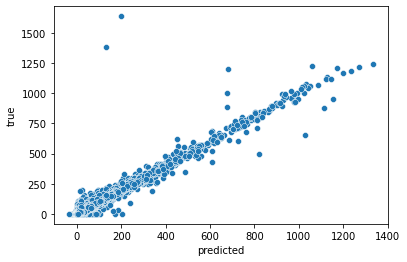

In [94]:
sns.scatterplot(x=data['predicted'], y=data['true'])

<AxesSubplot:xlabel='predicted', ylabel='true'>

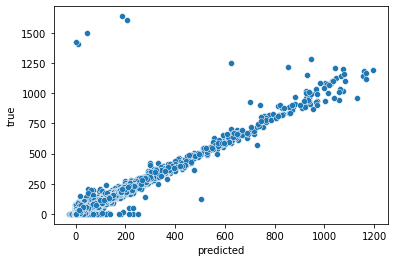

In [36]:
# Jan 2019
sns.scatterplot(x=data['predicted'], y=data['true'])

<AxesSubplot:xlabel='predicted', ylabel='true'>

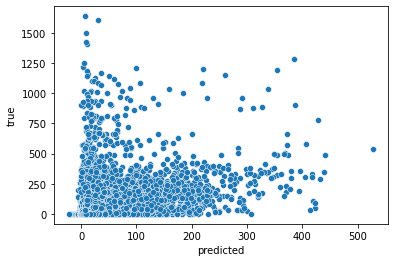

In [218]:
sns.scatterplot(x=data['predicted'], y=data['true'])

# Evaluation

In [95]:
results = {}
# results[month_year + ' without scheduled departe and arrival'] = r2_score(data['true'], data['predicted'])
# results[month_year + ' with scheduled departure and arrival'] = r2_score(data['true'], data['predicted'])
# results[month_year + ' with split scheduled departure and arrival times'] = r2_score(data['true'], data['predicted'])
results[month_year + ' including wheels off'] = r2_score(data['true'], data['predicted'])

In a prior run, AutoML was not able to produce good results (the feature set was highly limited though).

In [96]:
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['r2'])
df_results

,r2
Apr_2019 including wheels off,0.962989


In [216]:
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['r2'])
df_results

,r2
Jan_2019 with split scheduled departure and arrival times,0.185273


In [134]:
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['r2'])
df_results

,r2
Jan_2019 without scheduled departe and arrival,0.145449
Jan_2019 with scheduled departure and arrival,0.187276


# Generalisation

In [97]:
month_year = 'Apr_2020'
timestamp_suffix = strftime('%Y%m%d-%H%M')
auto_ml_month_name = month_year.replace('_', '-')
auto_ml_job_name = f'niy-{auto_ml_month_name}-' + timestamp_suffix
print('AutoMLJobName: ' + auto_ml_job_name)

AutoMLJobName: niy-Apr-2020-20201202-1627


In [98]:
df_general = get_preproccessed_df(file_uris[month_year])

In [100]:
file_path_general = f'/Users/yasinedin/Downloads/automl/generalisation/{month_year}.csv'
df_general.drop('ARR_DELAY_NEW', axis=1).to_csv(file_path_general, index=False, header=False)

# upload data to s3
try:
    general_response = s3_client.upload_file(file_path_general, bucket_name, f'automl/generalisation/{month_year}.csv')
    print('Generalisation data was successfully uploaded')
except ClientError as e:
    logging.error(e)
    print('Something went wrong.')

Train data successfully uploaded


In [101]:
transform_job_name = f'niy-trf-{auto_ml_month_name}-' + timestamp_suffix

transform_input = {
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': f's3://{bucket_name}/automl/generalisation/{month_year}.csv'
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    }

transform_output = {
        'S3OutputPath': f's3://{bucket_name}/automl/generalisation/inference-results',
    }

transform_resources = {
        'InstanceType': 'ml.m5.4xlarge',
        'InstanceCount': 1
    }

sm.create_transform_job(TransformJobName = transform_job_name,
                        ModelName = model_name,
                        TransformInput = transform_input,
                        TransformOutput = transform_output,
                        TransformResources = transform_resources
)

print ('JobStatus')
print('----------')

describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
job_run_status = describe_response['TransformJobStatus']
print (job_run_status)

while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
    job_run_status = describe_response['TransformJobStatus']
    print (job_run_status)
    sleep(120)

JobStatus
----------
InProgress
InProgress
InProgress
InProgress
Completed


In [102]:
s3_output_key = f'automl/generalisation/inference-results/{month_year}.csv.out'
local_inference_results_path = f'{month_year}_inference_results.csv'

inference_results_bucket = s3.Bucket(bucket_name)
inference_results_bucket.download_file(s3_output_key, local_inference_results_path);

data = pd.read_csv(local_inference_results_path, sep=';', names=['predicted'])

In [103]:
data['true'] = df_general['ARR_DELAY_NEW']

<AxesSubplot:xlabel='predicted', ylabel='true'>

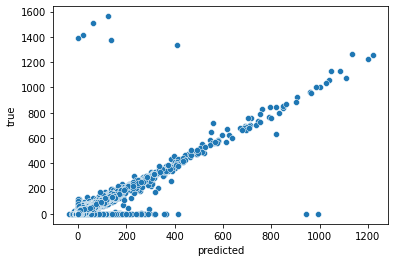

In [104]:
# Apr 2020
sns.scatterplot(x=data['predicted'], y=data['true'])

<AxesSubplot:xlabel='predicted', ylabel='true'>

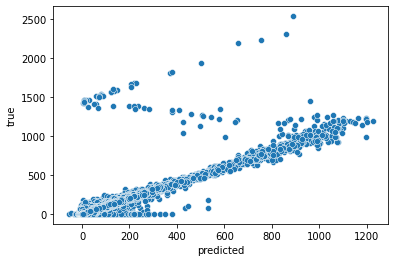

In [57]:
# Jan 2020
sns.scatterplot(x=data['predicted'], y=data['true'])

In [105]:
results = {}
# results[month_year + ' without scheduled departe and arrival'] = r2_score(data['true'], data['predicted'])
# results[month_year + ' with scheduled departure and arrival'] = r2_score(data['true'], data['predicted'])
# results[month_year + ' with split scheduled departure and arrival times'] = r2_score(data['true'], data['predicted'])
results[month_year + ' generalisation_covid'] = r2_score(data['true'], data['predicted'])

In [106]:
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['r2'])
df_results

,r2
Apr_2020 generalisation_covid,0.795245


In [59]:
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['r2'])
df_results

,r2
Jan_2020 generalisation,0.880186
